**We will predict the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.**


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [110]:
med_df=pd.read_csv("medical-charges.csv")

In [111]:
med_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [112]:
med_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The "charges" column seems to be significantly skewed(right skewed) however, as the median (50 percentile) is much lower than the mean.

Check for null values.

In [113]:
med_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [114]:
med_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

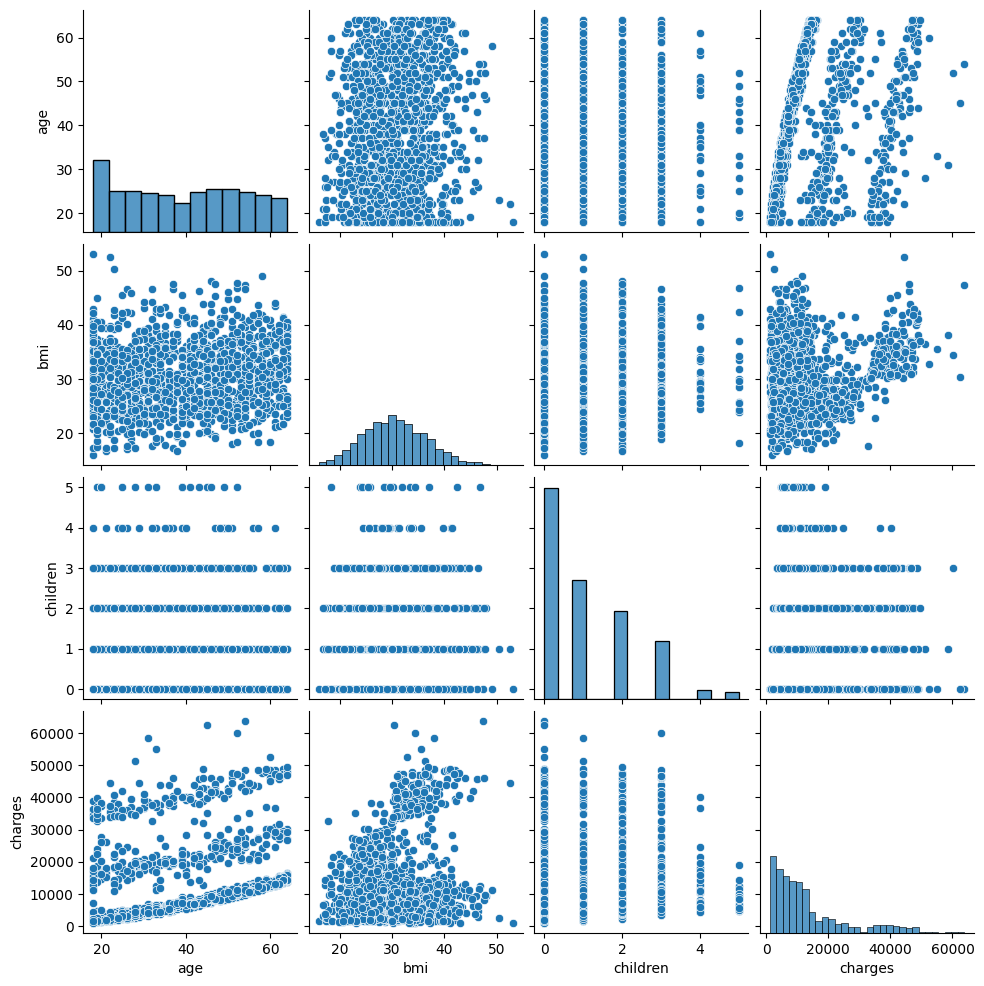

In [115]:
sns.pairplot(med_df)

<Axes: xlabel='charges', ylabel='Count'>

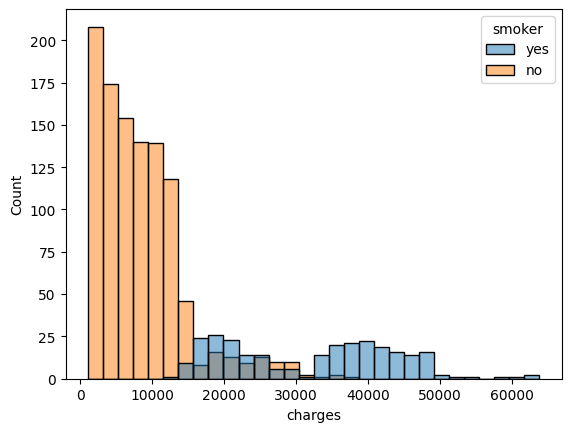

In [116]:
#Check out the distribution of the column we want to predict
sns.histplot(data=med_df, x="charges", hue="smoker")

We can make the following observations from the above graph:

For most customers, the annual medical charges are under \$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. 

There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \
7300 the median for smokers is close to 35,000.

In [117]:
med_df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [118]:
# sns.scatterplot(data=med_df, x="age", y="charges",hue="smoker", palette="deep")
# Using plotly to make interactive graphs
fig = px.scatter(med_df, x="age", y="charges", color="smoker", symbol="smoker")
fig.show()

In [119]:
fig = px.scatter(med_df, x="age", y="charges", color="sex", symbol="smoker")
fig.show()

Comparing both charts, we can see that charges increase depending on whether or not you smoke, irrespective of gender.

The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

In [120]:
# sns.scatterplot(data=med_df, x="age", y="charges",hue="smoker", palette="deep")
px.scatter(med_df,x="age", y="charges",color="smoker" )

In [121]:
# sns.scatterplot(data=med_df, x="age", y="charges",hue="region", palette="deep")
px.scatter(med_df,x="age", y="charges",color="region", size="age" )

In [122]:
med_df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [123]:
med_df['region'].value_counts()['southwest']

325

In [124]:
med_df['region'].value_counts()['northeast']

324

In [125]:
med_df['region'].value_counts()['northwest']

325

In [126]:
med_df['region'].value_counts()['southeast']

364

southeast region has highest population.

In [127]:
med_df[med_df.region=="southwest"].count()

age         325
sex         325
bmi         325
children    325
smoker      325
region      325
charges     325
dtype: int64

In [128]:
smoker_values={'no':0,'yes':1}
med_df['smoker_numeric']=med_df.smoker.map(smoker_values)

In [129]:
med_df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_numeric
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


In [130]:
# med_df.charges.corr(med_df.age)
medical_df=med_df[['age', 'bmi', 'children', 'charges']]

In [131]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<Axes: >

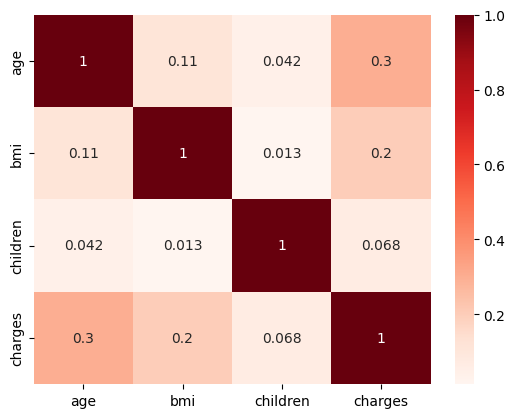

In [132]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)

age and smoker column have strongest correlation with "charges". Estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [133]:
non_smoker_df = medical_df[med_df.smoker == 'no']

In [134]:
non_smoker_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064 entries, 1 to 1336
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   bmi       1064 non-null   float64
 2   children  1064 non-null   int64  
 3   charges   1064 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.6 KB


<Axes: title={'center': 'Age vs. Charges'}, xlabel='age', ylabel='charges'>

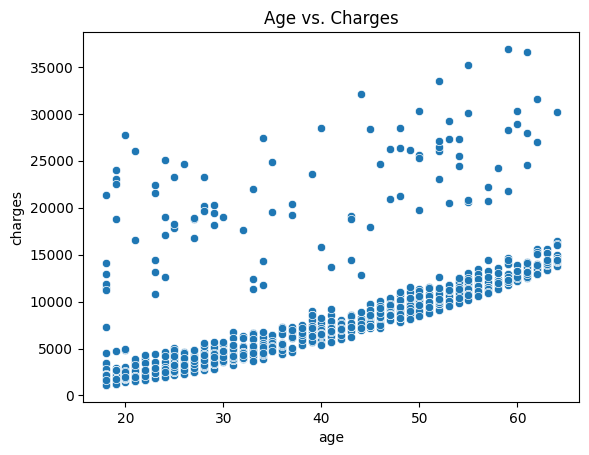

In [135]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges')

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assuming the following relationship between the two:

**charges = w×age+b**

We'll try determine w and b for the line that best fits the data.

In [136]:
ages = non_smoker_df['age'].values
charges = non_smoker_df['charges'].values
# estimated_charges = estimate_charges(ages, w, b)

In [137]:
# Mean X and Y
mean_ages = np.mean(ages)
mean_charges = np.mean(charges)
# mean_charges

In [138]:
# Total number of values
n = len(charges)
n

1064

In [139]:
# using the formula to calculate m & c
n = len(ages)
numer = 0
denom = 0

for i in range(n):
  numer += ((ages[i] - mean_ages) * (charges[i] - mean_charges))
  denom += ((ages[i] - mean_ages) ** 2)


m = (numer / denom)
c = mean_charges - (m * mean_ages)

print (f'm = {m} \nc = {c}')

m = 267.2489128311986 
c = -2091.4205565650445


Now that we’ve our m & c, let’s calculate the predicted charges using the equation of a line and plot the input points and the regression line.

In [140]:
def estimate_charges(age, m, c):
    return m * age + c

In [141]:
estimated_charges = estimate_charges(ages, m, c)

In [142]:
# w = 50
# b = 100
# ages = non_smoker_df.age
# estimated_charges = estimate_charges(ages, w, b)

In [143]:
# plt.plot(ages, estimated_charges, 'b-*')
# plt.xlabel('Age')
# plt.ylabel('Estimated Charges')

As expected, the points lie on a straight line.

We can overlay this line on the actual data to see how well our model fits the data.

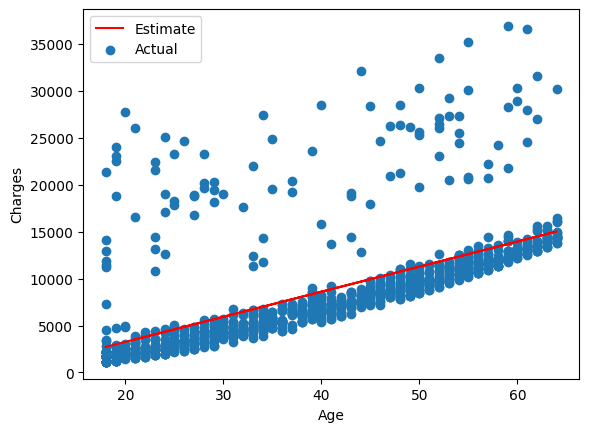

In [144]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r')

plt.scatter(ages, target)
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual'])

In [145]:
def try_parameters(w,b):
    target = non_smoker_df.charges
    ages = non_smoker_df.age
    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r')

    plt.scatter(ages, target)
    plt.xlabel('Age')
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual'])
    
    


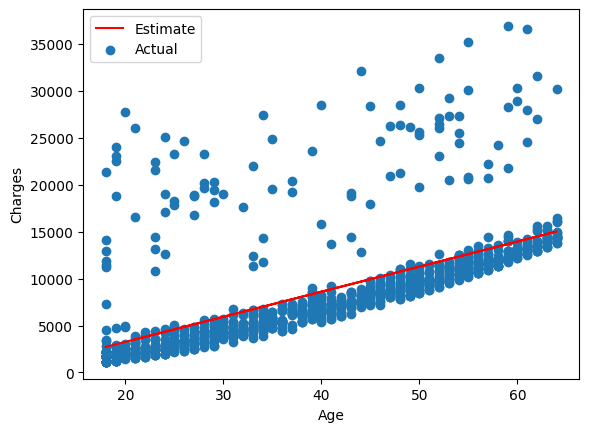

In [146]:
try_parameters(m, c)

**Loss/Cost Function**

We can compare our model's predictions with the actual targets using the following method:

Calculate the difference between the targets and predictions (the differenced is called the "residual")
Square all elements of the difference matrix to remove negative values.
Calculate the average of the elements in the resulting matrix.
Take the square root of the result

In [147]:
def rmse(targets,predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [148]:
# try_parameters(270, -3500)

In [149]:
targets = non_smoker_df.charges
predicted = estimate_charges(non_smoker_df.age, m, c)


In [150]:
rmse(targets, predicted)

4662.505766636395

Modifying try_parameters function to calculate loss.

In [157]:
def try_parameters(m, c):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, m, c)

    plt.plot(ages, predictions, 'r')
    plt.scatter(ages, target)
    plt.xlabel('Age')
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual'])
    
    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  4662.505766636395


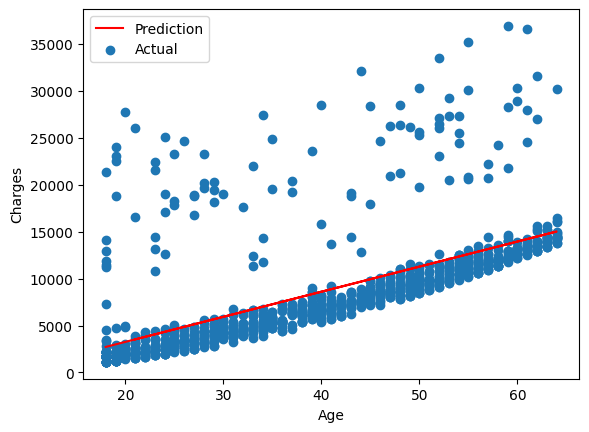

In [158]:
# try_parameters(270, -3500)
try_parameters(m, c)